# 

In [1]:
import numpy as np
import os
import keras
from keras.layers import LSTM
from keras.layers import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D, Input, concatenate
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape, Bidirectional
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from prettytable import PrettyTable

In [2]:
'''
# Set the directory path where the text files are located
dir_path = "/kaggle/input/best-lip-reading-dataset/outputs"

# Set the dimensions of each frame
height, width, channels = 80, 112, 3

# Initialize arrays to store the video frames and their corresponding labels
videos = []
labels = []
counter = 0
# Loop through each text file and extract the video frames
for root, dirs, files in os.walk(dir_path):
    

    for file in files:
        if file == "data.txt":

            # Extract the label from the directory name
            label = root.split("/")[-1]
            label = label.split("_")[0]
            #if label not in wanted_words:
            #    continue
            counter += 1
            print(counter, end=" ")
            

            with open(os.path.join(root, file), 'r') as f:
                data_str = f.read()

            # Evaluate the contents of the text file as a Python expression
            data_list = eval(data_str)
            
            # Convert the list to a numpy array
            data_array = np.array(data_list)
            #print(data_array.shape)

            # Reshape the data into a 4D array of shape (num_frames, height, width, channels)
            num_frames = len(data_list)
            frames = data_array.reshape((num_frames, height, width, channels))
            # Append the frames and label to the videos and labels arrays
            videos.append(frames)
            labels.append(label)
print(labels)

# Convert the videos and labels arrays to NumPy arrays
videos = np.array(videos)
labels = np.array(labels)

# Save the videos and labels as separate .npy files
np.save("videosCorrect.npy", videos)
np.save("labelsCorrect.npy", labels)
'''

videos = np.load('/kaggle/input/converted-nparray/videosCorrect.npy')
labels = np.load('/kaggle/input/converted-nparray/labelsCorrect.npy')

In [3]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (681, 22, 80, 112, 3)
Labels shape: (681,)


In [4]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = encoded_labels

In [5]:
label_dict = {6: 'hello', 5: 'dog', 10: 'my', 12: 'you', 9: 'lips', 3: 'cat', 11: 'read', 0: 'a', 4: 'demo', 7: 'here', 8: 'is', 1: 'bye', 2: 'can'}

In [6]:
# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

del videos

Training set shape: (544, 22, 80, 112, 3) (544,)
Test set shape: (137, 22, 80, 112, 3) (137,)


In [7]:
gc.collect()
!cat /proc/meminfo | grep Mem

MemTotal:       32880800 kB
MemFree:        18627960 kB
MemAvailable:   28400080 kB


In [8]:
# Get the unique classes
classes = np.unique(labels)

# Count the number of occurrences of each class
counts = np.bincount(labels, minlength=len(classes))

# Find the maximum length of the class names for alignment
max_len = max([len(label_dict[i]) for i in range(len(label_dict))])

# Print the distribution of classes
for i, count in enumerate(counts):
    class_name = label_dict[i].ljust(max_len)
    print("{}  {} counts".format(class_name, count))

a      53 counts
bye    52 counts
can    51 counts
cat    49 counts
demo   52 counts
dog    50 counts
hello  48 counts
here   61 counts
is     54 counts
lips   53 counts
my     53 counts
read   54 counts
you    51 counts


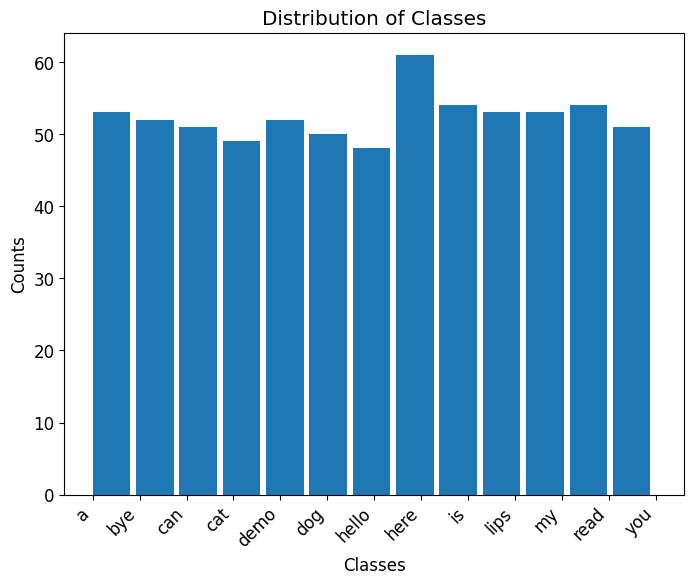

In [9]:
# Get the unique classes
classes = np.unique(labels)

# Count the number of occurrences of each class
counts = np.bincount(labels, minlength=len(classes))

# Set the figure size and font size
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})

# Plot the histogram
plt.hist(labels, bins=len(classes), width=0.8)
plt.xticks(range(len(classes)), [label_dict[i] for i in range(len(classes))], rotation=45, ha='right')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes')

# Display the plot
plt.show()

In [10]:
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, concatenate

input_shape = (22, 80, 112, 3)

# Single input
input_video = Input(shape=input_shape)


x1 = Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input_video)
x1 = MaxPooling3D((2, 2, 2))(x1)
x1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x1)
x1 = MaxPooling3D((2, 2, 2))(x1)
x1 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x1)
x1 = Flatten()(x1)


x2 = Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input_video)
x2 = MaxPooling3D((2, 2, 2))(x2)
x2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = MaxPooling3D((2, 2, 2))(x2)
x2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = Flatten()(x2)

# Concatenate both branches
concatenated = concatenate([x1, x2])

# Dense layers after concatenation
dense = Dense(1024, activation='relu')(concatenated)
dense = Dropout(0.5)(dense)
dense = Dense(256, activation='relu')(dense)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.5)(dense)

# Output layer
output = Dense(13, activation='softmax')(dense)

# Final model
model = Model(inputs=input_video, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22, 80,    │          0 │ -                 │
│ (InputLayer)        │ 112, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 22, 80,    │        656 │ input_layer[0][0] │
│                     │ 112, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 22, 80,    │        656 │ input_layer[0][0] │
│                     │ 112, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 11, 40,    │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 56, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 11, 40,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 56, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 11, 40,    │      6,944 │ max_pooling3d[0]… │
│                     │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 11, 40,    │      6,944 │ max_pooling3d_2[… │
│                     │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 5, 20, 28, │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 5, 20, 28, │          0 │ conv3d_4[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 5, 20, 28, │    110,720 │ max_pooling3d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 5, 20, 28, │    110,720 │ max_pooling3d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 358400)    │          0 │ conv3d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 358400)    │          0 │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 716800)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 734,004,2… │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    262,400 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0] 

 Total params: 734,520,557 (2.74 GB)

 Trainable params: 734,520,557 (2.74 GB)

 Non-trainable params: 0 (0.00 B)

In [11]:
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

In [12]:
# Train the model and record the history of training
#history = model.fit(X_train, y_train_onehot, epochs=20, batch_size=16, validation_data=(X_test, y_test_onehot))

history = model.fit(X_train, y_train_onehot, 
                    epochs=25, batch_size=8, 
                    validation_data=(X_test, y_test_onehot))


Epoch 1/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 846s 12s/step - accuracy: 0.0626 - loss: 1940.1603 - val_accuracy: 0.2336 - val_loss: 2.6458
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 901s 13s/step - accuracy: 0.1247 - loss: 2.6340 - val_accuracy: 0.4380 - val_loss: 2.1340
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 859s 13s/step - accuracy: 0.3395 - loss: 2.1709 - val_accuracy: 0.5620 - val_loss: 1.5354
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 833s 12s/step - accuracy: 0.4541 - loss: 1.8593 - val_accuracy: 0.6423 - val_loss: 1.2570
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 883s 13s/step - accuracy: 0.5091 - loss: 1.6309 - val_accuracy: 0.6204 - val_loss: 1.0469
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 868s 13s/step - accuracy: 0.6036 - loss: 1.2781 - val_accuracy: 0.7883 - val_loss: 1.0412
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 847s 12s/step - accuracy: 0.6880 - loss: 1.1405 - val_accuracy: 0.8686 - val_loss: 0.6712
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 873s 13s/step - accuracy: 0.7058 - loss: 1.0418 - val_accuracy:

"\nmodel = Sequential()\nmodel.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))\nmodel.add(MaxPooling3D((2, 2, 2)))\nmodel.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))\nmodel.add(MaxPooling3D((2, 2, 2)))\nmodel.add(Conv3D(256, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))\nmodel.add(Flatten())\nmodel.add(Dense(1024, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(13, activation='softmax'))\n\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n\n# Convert the target labels to one-hot encoding\ny_train_onehot = tf.keras.utils.to_categorical(y_train)\ny_test_onehot = tf.keras.utils.to_categorical(y_test)\nmodel.summary()\n"

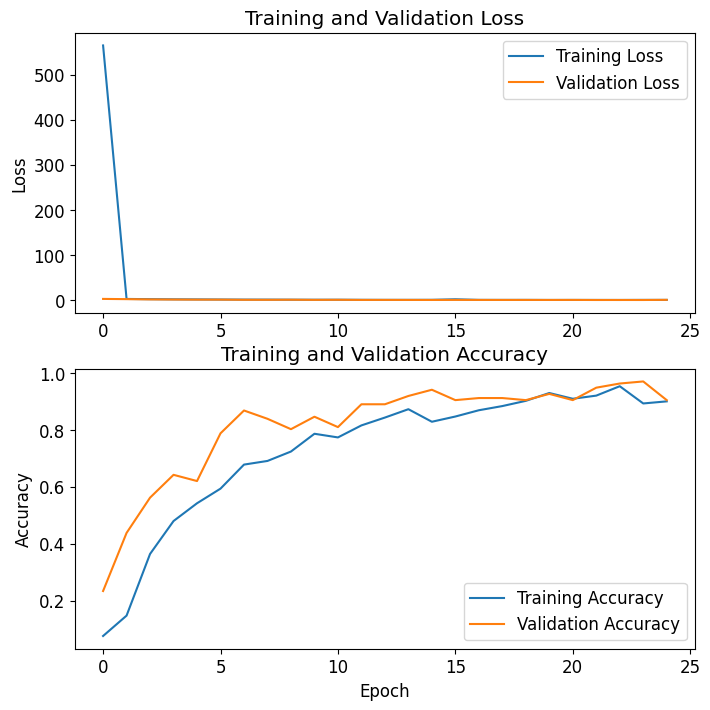

In [14]:
# Plot the training and validation loss and accuracy
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')

plt.xlabel('Epoch')
plt.show()

In [15]:
model.save_weights('model_weights_abir2.weights.h5')

In [16]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step


In [17]:
report = classification_report(y_test, y_pred, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|   a   |    0.85   |  0.92  |   0.88   |    12   |
|  bye  |    0.38   |  0.75  |   0.5    |    4    |
|  can  |    1.0    |  0.7   |   0.82   |    10   |
|  cat  |    0.9    |  0.6   |   0.72   |    15   |
|  demo |    1.0    |  1.0   |   1.0    |    10   |
|  dog  |    1.0    |  1.0   |   1.0    |    8    |
| hello |    0.77   |  0.91  |   0.83   |    11   |
|  here |    1.0    |  0.88  |   0.93   |    8    |
|   is  |    1.0    |  1.0   |   1.0    |    14   |
|  lips |    1.0    |  1.0   |   1.0    |    11   |
|   my  |    0.93   |  1.0   |   0.96   |    13   |
|  read |    0.92   |  1.0   |   0.96   |    11   |
|  you  |    1.0    |  1.0   |   1.0    |    10   |
+-------+-----------+--------+----------+---------+


In [18]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

Balanced accuracy: 0.9039044289044289


5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step


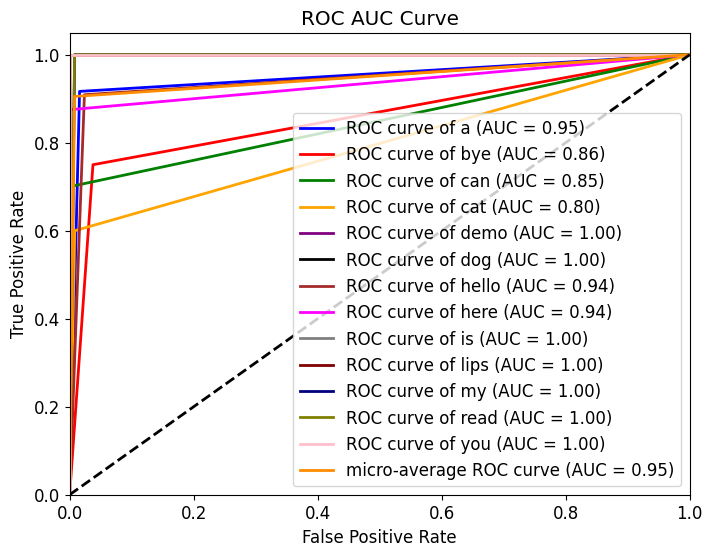

In [19]:
# Convert y_true and y_pred to one-hot encoding
n_classes = len(np.unique(y_test))
y_true_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = model.predict(X_test)
y_pred_bin = label_binarize(np.argmax(y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8,6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

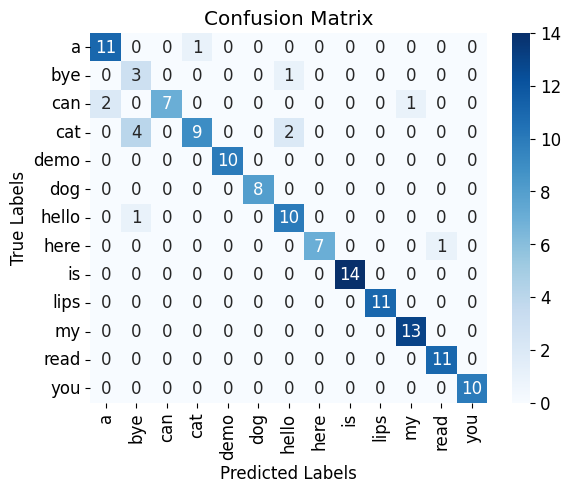

In [20]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()